<a href="https://colab.research.google.com/github/Gantaaa/Skin-Cancer-Detection-with-Deep-Learning/blob/main/FinalDeliverable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Deliverable (Skin Cancer Detection with Deep Learning)

## Environment Setup

I start by installing necessary libraries and importing the required packages

In [ ]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

## Mount Google Drive and Extract the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_filename = "/content/drive/My Drive/The Build Fellowship (Skin Cancer Detection with Deep Learning)/HAM10000.zip"
with ZipFile(zip_filename, 'r') as zip_ref:
  zip_ref.extractall()
  print('You got the dataset!')
print("Contents of /content directory:")
print(os.listdir('/content'))

You got the dataset!
Contents of /content directory:
['.config', 'HAM10000', 'drive', 'sample_data']


## Preprocessing to prepare train

In [ ]:
# loading Metadata

data_pd = pd.read_csv('/content/drive/My Drive/The Build Fellowship (Skin Cancer Detection with Deep Learning)/HAM10000_metadata.csv')
print("You'll see the first 5 datas from the dataset: ")
print(data_pd.head())

# handling duplicate lesions
df_count = data_pd.groupby('lesion_id').count().reset_index()
df_count = df_count[df_count['dx'] == 1]

def duplicates(x):
  unique = set(df_count['lesion_id'])
  return 'no' if x in unique else 'duplicate'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd = data_pd[data_pd['is_duplicate'] == 'no']

# handling missing values & encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_pd['label_encoded'] = le.fit_transform(data_pd['dx'])
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))

# splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_pd, test_size=0.15, stratify=data_pd['dx'], random_state=42)

# marking images as train or testing bades on split
def identify_train0rtest(image_id):
  test_ids = set(test_df['image_id'].astype(str))
  return 'test' if str(image_id) in test_ids else 'train'

data_pd['train_test_split'] = data_pd['image_id'].apply(identify_train0rtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']

data_pd.set_index('image_id', inplace=True)

You'll see the first 5 datas from the dataset: 
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


## Visualization

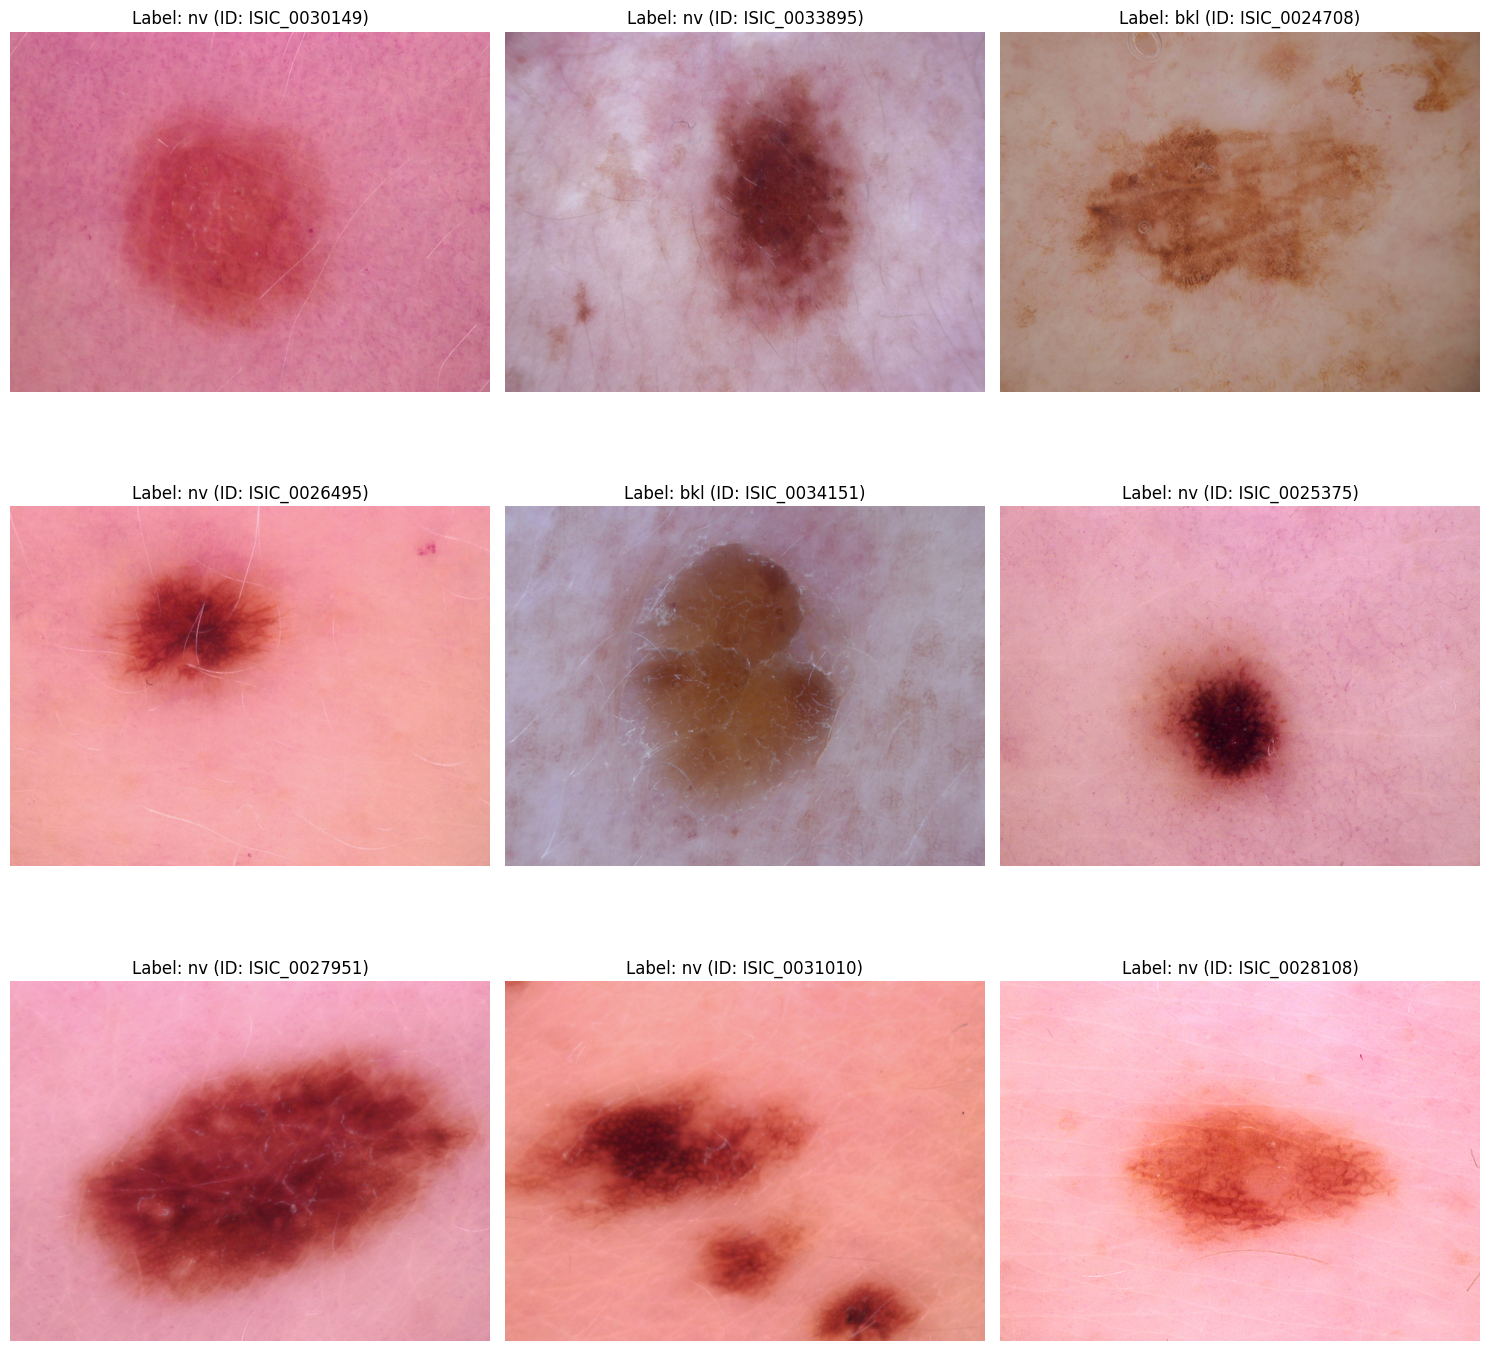

In [ ]:
# displaying a few sample images from each classes
import cv2

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
sample_data = data_pd.sample(9)

for i, (idx, row) in enumerate(sample_data.iterrows()):
    # using the index (which is the image_id) instead of row['image_id']
    img_path = os.path.join('/content/HAM10000', idx + '.jpg')

    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i//3, i%3].imshow(img)
        axes[i//3, i%3].set_title(f"Label: {row['dx']} (ID: {idx})")
        axes[i//3, i%3].axis('off')
    else:
        print(f"Warning: Could not load image at {img_path}")
        # Display a blank image or skip if image not found
        axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

## Create Directories and Copy Images (To Save Ram)

In [ ]:

# base paths
base_dir = '/content/HAM10000'
work_dir = '/content/skin_cancer_split'

# create main directories for train and test
os.makedirs(work_dir, exist_ok=True)
train_dir = os.path.join(work_dir, 'train')
test_dir = os.path.join(work_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# create a subdirectory for each class within train and test
for label in data_pd['dx'].unique():
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# now copy the images from the main folder to the new train/test class folders
# this code loops through train/test splits and moves the files
for _, row in train_df.iterrows():
    image_id = str(row['image_id'])  # make sure it's always a string
    label = row['dx']

    # try different file extensions
    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG']:
        src_path = os.path.join(base_dir, image_id + ext)
        if os.path.exists(src_path):
            dst_path = os.path.join(train_dir, label, image_id + ext)
            if not os.path.exists(dst_path):
                os.symlink(src_path, dst_path)
            break
    else:
        print(f"Warning: Could not find image for {image_id}")

for _, row in test_df.iterrows():
    image_id = str(row['image_id'])
    label = row['dx']

    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG']:
        src_path = os.path.join(base_dir, image_id + ext)
        if os.path.exists(src_path):
            dst_path = os.path.join(test_dir, label, image_id + ext)
            if not os.path.exists(dst_path):
                os.symlink(src_path, dst_path)
            break
    else:
        print(f"Warning: Could not find image for {image_id}")


print("Directory structure created successfully!")

Directory structure created successfully!


## Data Augmentation

In [ ]:
# first, let's analyze class distribution to understand imbalance
class_counts = {}
for label in data_pd['dx'].unique():
    class_dir = os.path.join(train_dir, label)
    class_counts[label] = len(os.listdir(class_dir))

print("Original class distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")

# set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# define parameters
aug_dir = 'aug_dir'
image_size = 224
max_data = 800

# create output directory if it doesn't exist
os.makedirs(aug_dir, exist_ok=True)

# use your tutor's label mapping (targetnames)
targetnames = data_pd['dx'].unique()

# define data augmentation
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# apply augmentation only to classes that need it
for label in targetnames:
    # create class subfolder in aug_dir
    label_output_dir = os.path.join(aug_dir, label)
    os.makedirs(label_output_dir, exist_ok=True)

    # get list of images in the original training folder for this label
    class_dir = os.path.join(train_dir, label)
    file_list = os.listdir(class_dir)

    images_for_class = []
    for file_name in file_list:
        img_path = os.path.join(class_dir, file_name)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        images_for_class.append(img_array)

    # convert list to array
    X_all = np.array(images_for_class, dtype=np.float32)
    n_images = len(X_all)

    # only augment if this class has fewer than max_data images
    if n_images < max_data:
        # save all existing images first
        for i, img_array in enumerate(X_all):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        # now figure out how many augmented images are needed
        needed = max_data - n_images

        # create a small generator for augmentation
        gen = datagen.flow(X_all, batch_size=1, shuffle=True)

        # generate and save the augmented images
        for i in range(needed):
            X_aug = next(gen)[0]  # gen outputs a batch of 1, shape (1, H, W, C)
            out_path = os.path.join(label_output_dir, f'aug_{i}.jpg')
            save_img(out_path, X_aug)

        print(f"Class '{label}': Saved {n_images} original + {needed} augmented images (total {max_data}).")
    else:
        # for classes with enough images, just copy them (no augmentation needed)
        for i, img_array in enumerate(X_all[:max_data]):  # Only take up to max_data
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)
        print(f"Class '{label}': Already has {n_images} images, saved {max_data} (no augmentation needed).")

print("Augmented dataset successfully created in:", aug_dir)

Original class distribution:
bkl: 374 images
nv: 3752 images
df: 33 images
mel: 196 images
vasc: 54 images
bcc: 149 images
akiec: 128 images
Class 'bkl': Saved 374 original + 426 augmented images (total 800).
Class 'nv': Already has 3752 images, saved 800 (no augmentation needed).
Class 'df': Saved 33 original + 767 augmented images (total 800).
Class 'mel': Saved 196 original + 604 augmented images (total 800).
Class 'vasc': Saved 54 original + 746 augmented images (total 800).
Class 'bcc': Saved 149 original + 651 augmented images (total 800).
Class 'akiec': Saved 128 original + 672 augmented images (total 800).
Augmented dataset successfully created in: aug_dir


## Visualization for samples from the augmented dataset

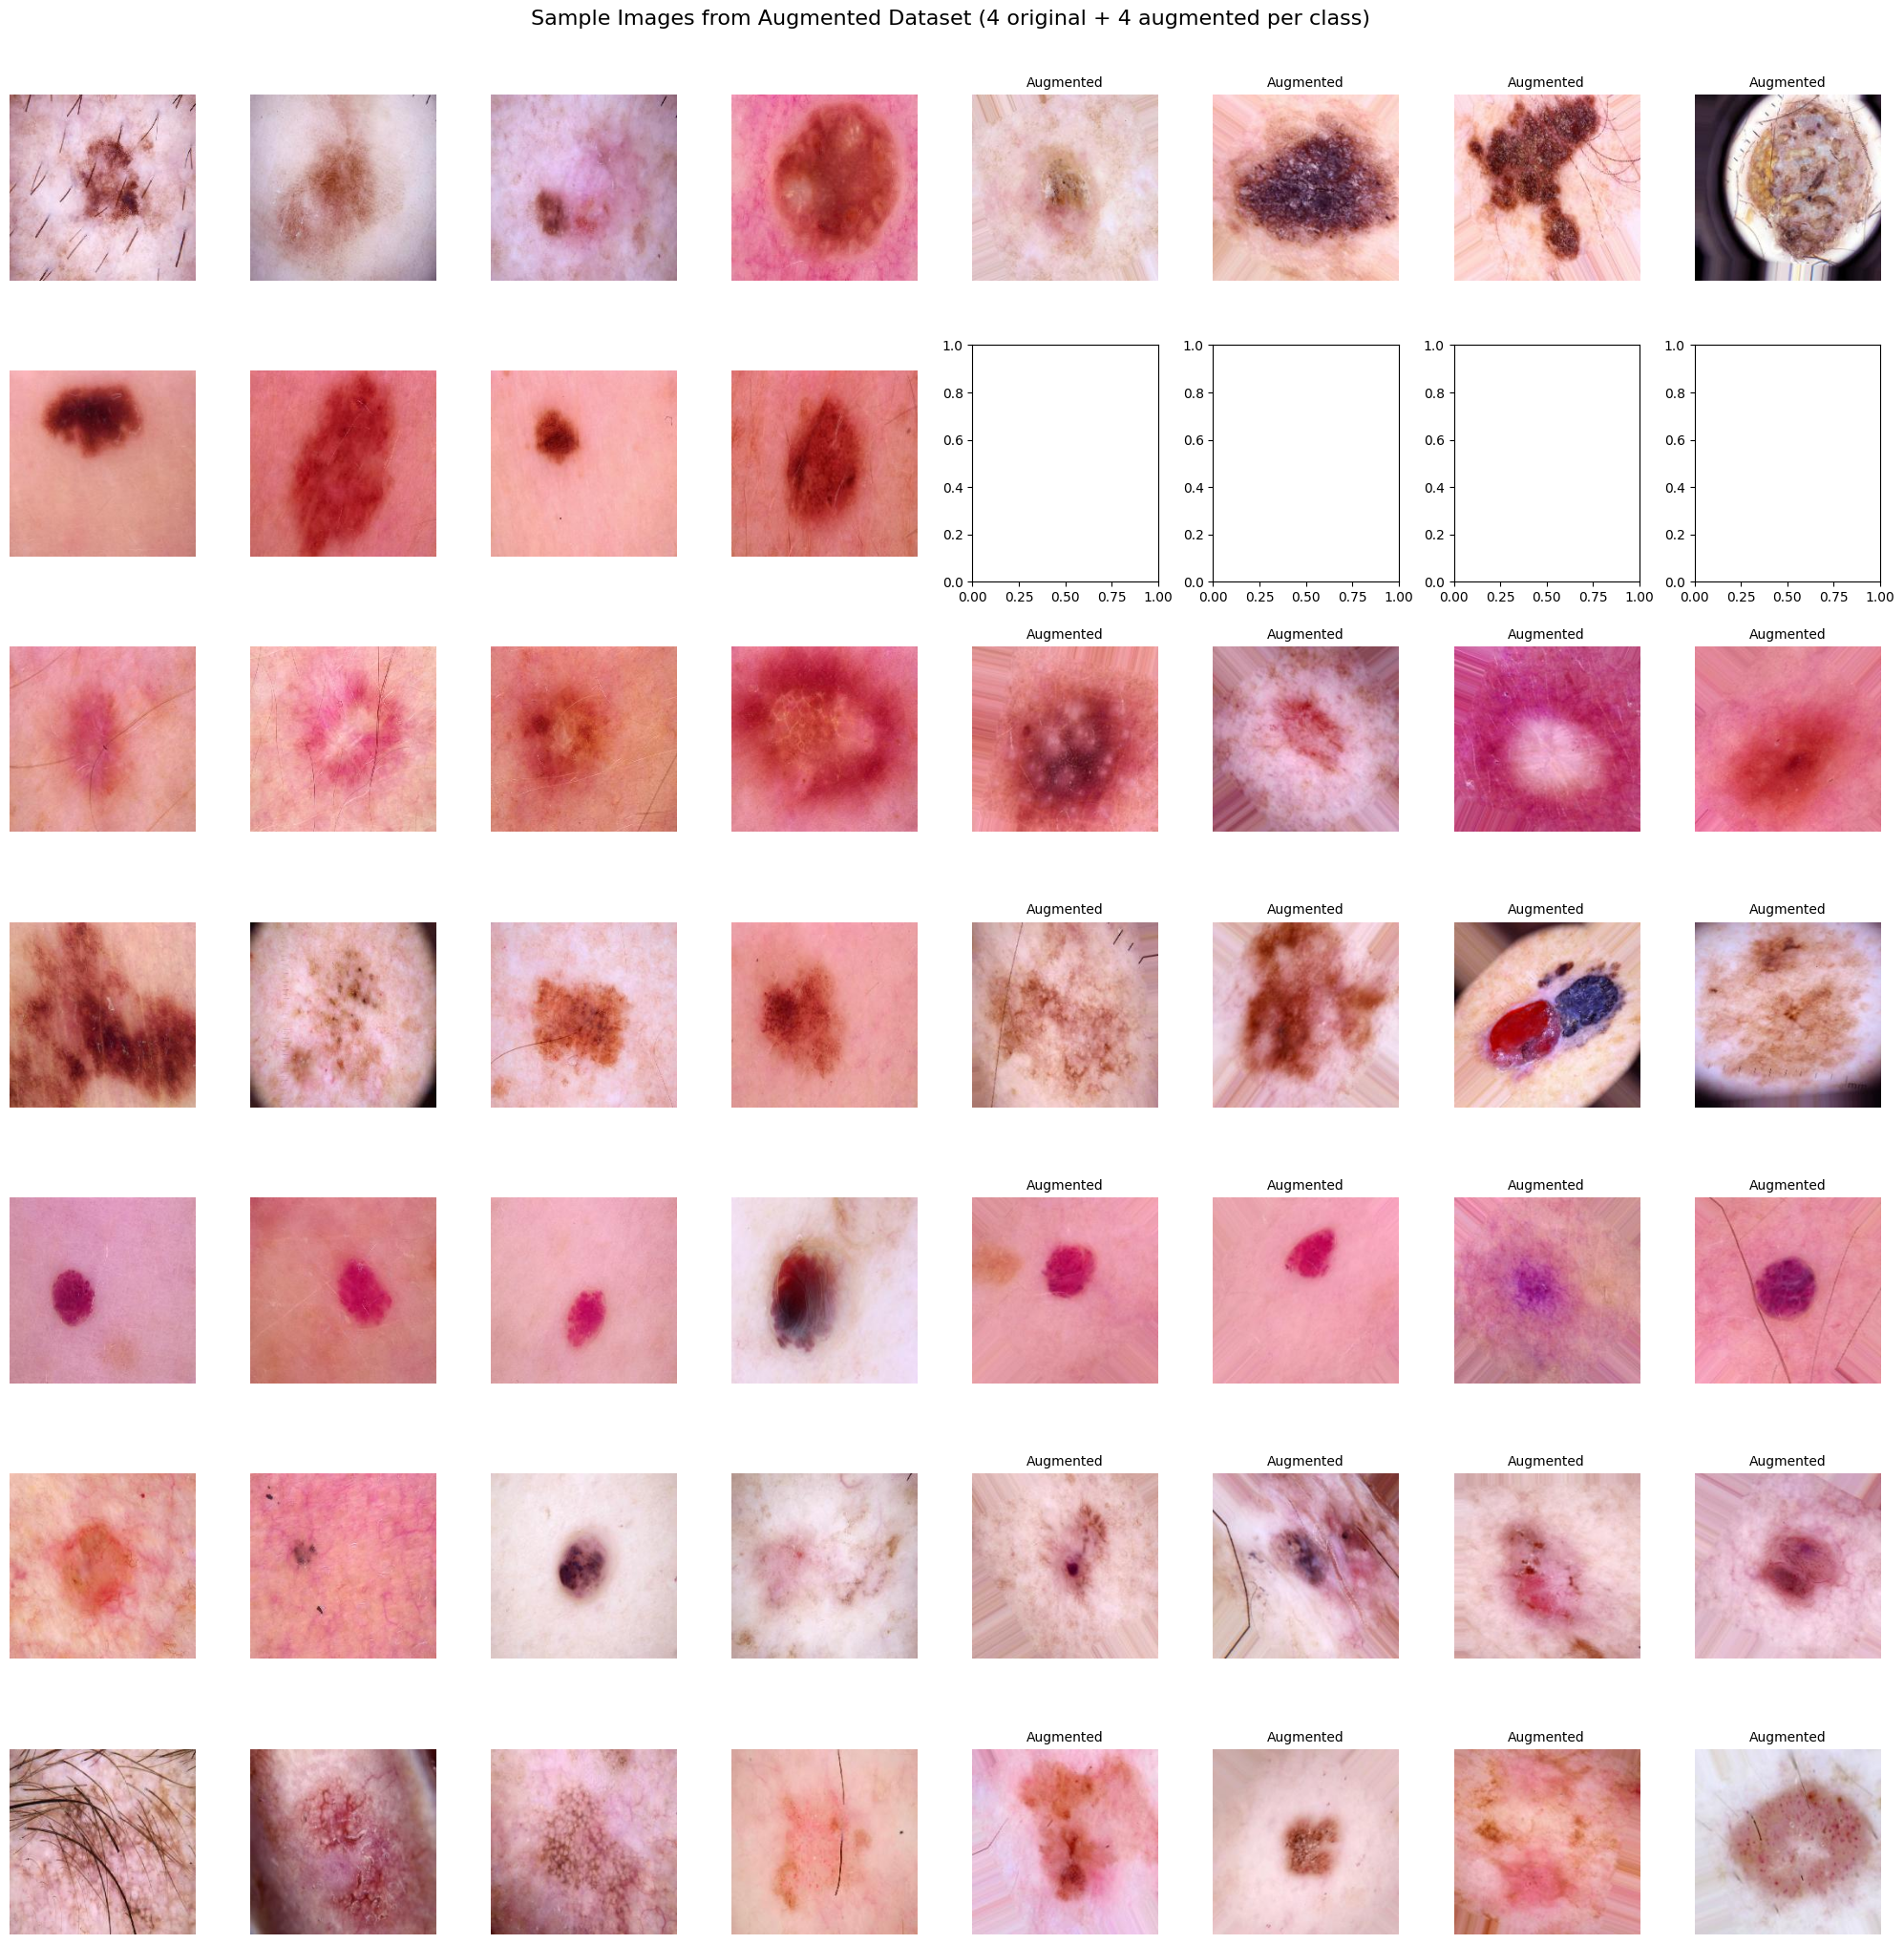

Combined training dataset created at: /content/combined_train


In [ ]:
# now visualize samples from the augmented dataset
import matplotlib.pyplot as plt

# create a figure with subplots for each class
fig, axes = plt.subplots(len(targetnames), 8, figsize=(20, 3*len(targetnames)))
fig.suptitle('Sample Images from Augmented Dataset (4 original + 4 augmented per class)', fontsize=16)

for row_idx, label in enumerate(targetnames):
    class_dir = os.path.join(aug_dir, label)
    img_files = os.listdir(class_dir)

    # get 4 original and 4 augmented images
    original_imgs = [f for f in img_files if f.startswith('original_')][:4]
    augmented_imgs = [f for f in img_files if f.startswith('aug_')][:4]
    sample_imgs = original_imgs + augmented_imgs

    for col_idx, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_dir, img_file)
        ax = axes[row_idx, col_idx]
        ax.imshow(load_img(img_path))
        ax.axis('off')

        # add label to first column
        if col_idx == 0:
            ax.set_ylabel(label, rotation=0, ha='right', va='center', fontsize=12)

        # add "Augmented" label to augmented images
        if col_idx >= 4:
            ax.set_title("Augmented", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # adjust for suptitle
plt.show()

# now create a combined training directory that includes both original and augmented data
combined_train_dir = '/content/combined_train'

# remove the existing directory if it exists to start fresh
import shutil
if os.path.exists(combined_train_dir):
    shutil.rmtree(combined_train_dir)

os.makedirs(combined_train_dir, exist_ok=True)

# for each class, create a directory in the combined folder
for label in targetnames:
    os.makedirs(os.path.join(combined_train_dir, label), exist_ok=True)

    # copy all images from the augmented directory
    aug_class_dir = os.path.join(aug_dir, label)
    for img_file in os.listdir(aug_class_dir):
        src_path = os.path.join(aug_class_dir, img_file)
        dst_path = os.path.join(combined_train_dir, label, img_file)

        # use symlinks to save space (or copy if needed)
        if not os.path.exists(dst_path):
            os.symlink(src_path, dst_path)
        else:
            # if the symlink already exists, remov it first
            os.remove(dst_path)
            os.symlink(src_path, dst_path)

print(f"Combined training dataset created at: {combined_train_dir}")

## Load test images using ImageDataGenerator

In [ ]:

# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# only rescaling for validation/test
test_datagen = ImageDataGenerator(rescale=1./255)

# create data generators
batch_size = 32
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    combined_train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,  # this should point to my test directory
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Found 5600 images belonging to 7 classes.
Found 828 images belonging to 7 classes.
Number of classes: 7


## Preperation for all models

In [ ]:
print("Preparing data for all models with direct loading...")

# first check what directories actually exist
print("Checking directory structure...")
print("Combined train dir exists:", os.path.exists(combined_train_dir))
if os.path.exists(combined_train_dir):
    print("Contents of combined_train:", os.listdir(combined_train_dir))
    for label in os.listdir(combined_train_dir):
        label_dir = os.path.join(combined_train_dir, label)
        if os.path.isdir(label_dir):
            print(f"  {label}: {len(os.listdir(label_dir))} images")

print("Test dir exists:", os.path.exists(test_dir))
if os.path.exists(test_dir):
    print("Contents of test:", os.listdir(test_dir))

# use the original train_dir instead of combined_train_dir since symlinks might be broken
# loading images directly from the original directories

# function to load images directly from source directories
def load_images_from_source(data_df, base_dir, img_size=(224, 224), max_per_class=None):
    X = []
    y = []
    class_counts = {}

    for label in data_df['dx'].unique():
        class_data = data_df[data_df['dx'] == label]
        if max_per_class:
            class_data = class_data.sample(min(len(class_data), max_per_class), random_state=42)

        class_images = []
        for _, row in class_data.iterrows():
            image_id = str(row['image_id'])

            # try different file extensions
            for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG']:
                img_path = os.path.join(base_dir, image_id + ext)
                if os.path.exists(img_path):
                    try:
                        img = load_img(img_path, target_size=img_size)
                        img_array = img_to_array(img) / 255.0
                        class_images.append(img_array)
                        y.append(label)
                        break
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
                        continue
            else:
                print(f"Warning: Could not find image for {image_id}")

        X.extend(class_images)
        class_counts[label] = len(class_images)

    return np.array(X), np.array(y), class_counts

# prepare training data (use original images, not augmented)
print("Loading training data...")
X_train, y_train, train_counts = load_images_from_source(train_df, base_dir, img_size=(224, 224), max_per_class=1000)
print("Training data loaded. Shape:", X_train.shape)

# prepare test data
print("Loading test data...")
X_test, y_test, test_counts = load_images_from_source(test_df, base_dir, img_size=(224, 224))
print("Test data loaded. Shape:", X_test.shape)

# flatten images for ML models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
class_names = le.classes_

print(f"Final training data shape: {X_train_flat.shape}")
print(f"Final test data shape: {X_test_flat.shape}")
print("Class distribution - Training:", train_counts)
print("Class distribution - Test:", test_counts)

Preparing data for all models with direct loading...
Checking directory structure...
Combined train dir exists: True
Contents of combined_train: ['mel', 'akiec', 'bkl', 'bcc', 'nv', 'df', 'vasc']
  mel: 800 images
  akiec: 800 images
  bkl: 800 images
  bcc: 800 images
  nv: 800 images
  df: 800 images
  vasc: 800 images
Test dir exists: True
Contents of test: ['mel', 'akiec', 'bkl', 'bcc', 'nv', 'df', 'vasc']
Loading training data...
Training data loaded. Shape: (1934, 224, 224, 3)
Loading test data...
Test data loaded. Shape: (828, 224, 224, 3)
Final training data shape: (1934, 150528)
Final test data shape: (828, 150528)
Class distribution - Training: {'bkl': 374, 'nv': 1000, 'df': 33, 'mel': 196, 'vasc': 54, 'bcc': 149, 'akiec': 128}
Class distribution - Test: {'nv': 663, 'bkl': 66, 'mel': 34, 'bcc': 26, 'vasc': 10, 'df': 6, 'akiec': 23}


## Model 1: Logistic Regression

Training Logistic Regression Model...
Logistic Regression Accuracy: 0.7790

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       akiec       0.23      0.13      0.17        23
         bcc       0.35      0.35      0.35        26
         bkl       0.31      0.42      0.36        66
          df       0.50      0.17      0.25         6
         mel       0.12      0.15      0.14        34
          nv       0.92      0.90      0.91       663
        vasc       0.29      0.20      0.24        10

    accuracy                           0.78       828
   macro avg       0.39      0.33      0.34       828
weighted avg       0.79      0.78      0.78       828



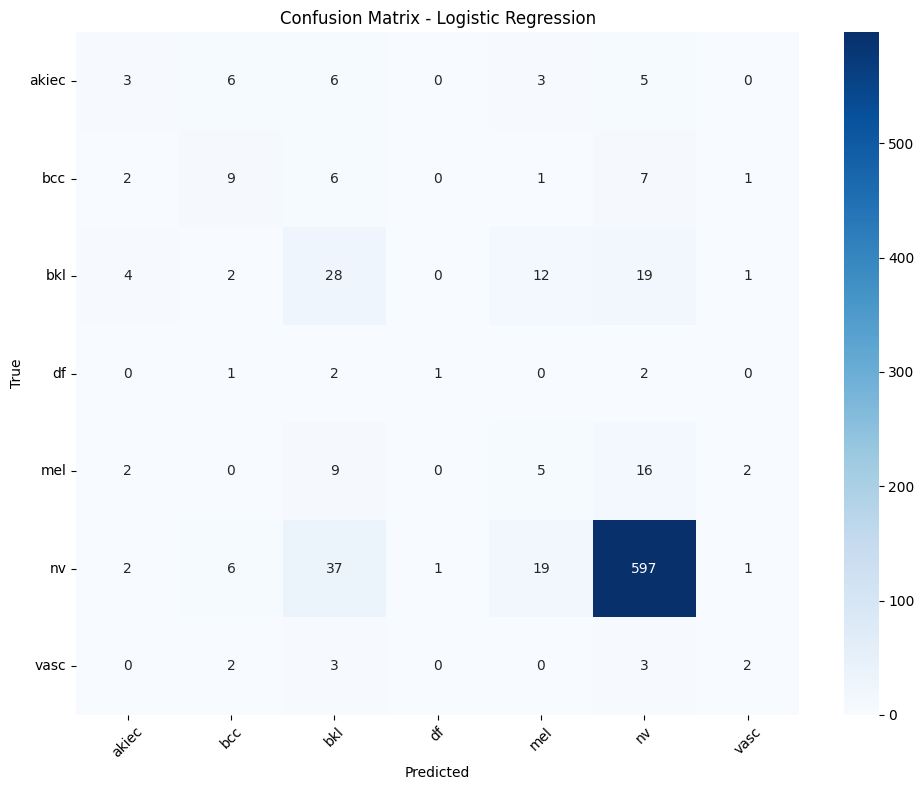

In [ ]:

print("Training Logistic Regression Model...")

# train Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
logreg_model.fit(X_train_flat, y_train_encoded)

# make predictions
y_pred_logreg = logreg_model.predict(X_test_flat)

# calculate accuracy
logreg_accuracy = accuracy_score(y_test_encoded, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")

# detailed classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_encoded, y_pred_logreg, target_names=class_names))

# confusion Matrix
plt.figure(figsize=(10, 8))
cm_logreg = confusion_matrix(y_test_encoded, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Model 2: Neural Network

Training Artificial Neural Network(ANN)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.3279 - loss: 6.0042 - val_accuracy: 0.8007 - val_loss: 1.1296
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.5191 - loss: 1.4801 - val_accuracy: 0.8007 - val_loss: 0.9787
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.5310 - loss: 1.3922 - val_accuracy: 0.8007 - val_loss: 0.7591
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.5332 - loss: 1.3345 - val_accuracy: 0.8007 - val_loss: 1.0249
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5331 - loss: 1.3573 - val_accuracy: 0.8007 - val_loss: 0.7904
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5321 - loss: 1.3148 - val_accuracy: 0.8007 - val_loss: 0.8582
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.5332 - loss: 1.3361 - val_accuracy: 0.8007 - val_loss: 0.7788
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.5332 - loss: 1.2878 - val_accuracy: 0.

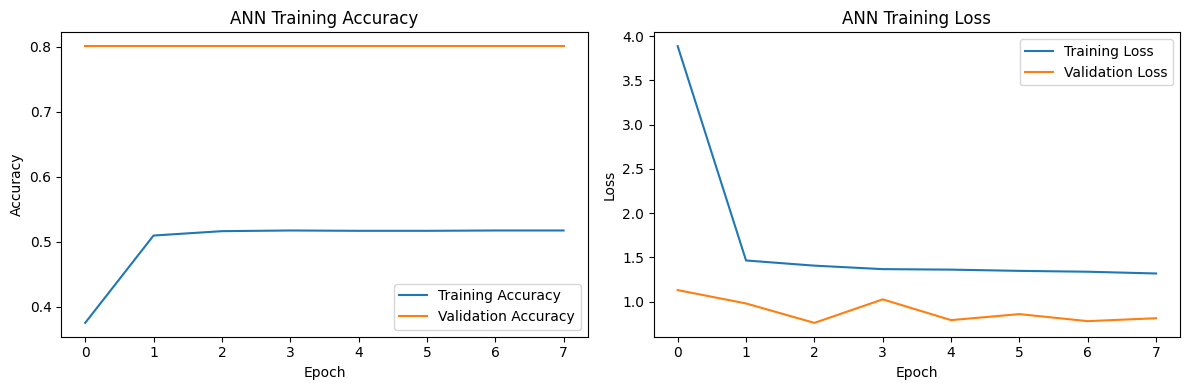

In [ ]:
print("Training Artificial Neural Network(ANN)...")

# convert labels to categorical for ANN
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded, num_classes=len(class_names))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(class_names))

# build ANN model
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_flat.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# compile the model
ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# train the model
ann_history = ann_model.fit(
    X_train_flat, y_train_categorical,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_flat, y_test_categorical),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# evaluate ANN
ann_loss, ann_accuracy = ann_model.evaluate(X_test_flat, y_test_categorical, verbose=0)
print(f"ANN Accuracy: {ann_accuracy:.4f}")

# plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['accuracy'], label='Training Accuracy')
plt.plot(ann_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ann_history.history['loss'], label='Training Loss')
plt.plot(ann_history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Model 3: CNN with ResNet50

Epoch 1/2
242/242 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - accuracy: 0.4859 - loss: 1.6345 - val_accuracy: 0.8007 - val_loss: 1.0387
Epoch 2/2
242/242 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.5312 - loss: 1.4827 - val_accuracy: 0.8007 - val_loss: 1.0354
242/242 ━━━━━━━━━━━━━━━━━━━━ 706s 3s/step - accuracy: 0.5360 - loss: 1.4193 - val_accuracy: 0.8007 - val_loss: 1.4306
Simplified Hybrid Accuracy: 0.8007
26/26 ━━━━━━━━━━━━━━━━━━━━ 168s 6s/step


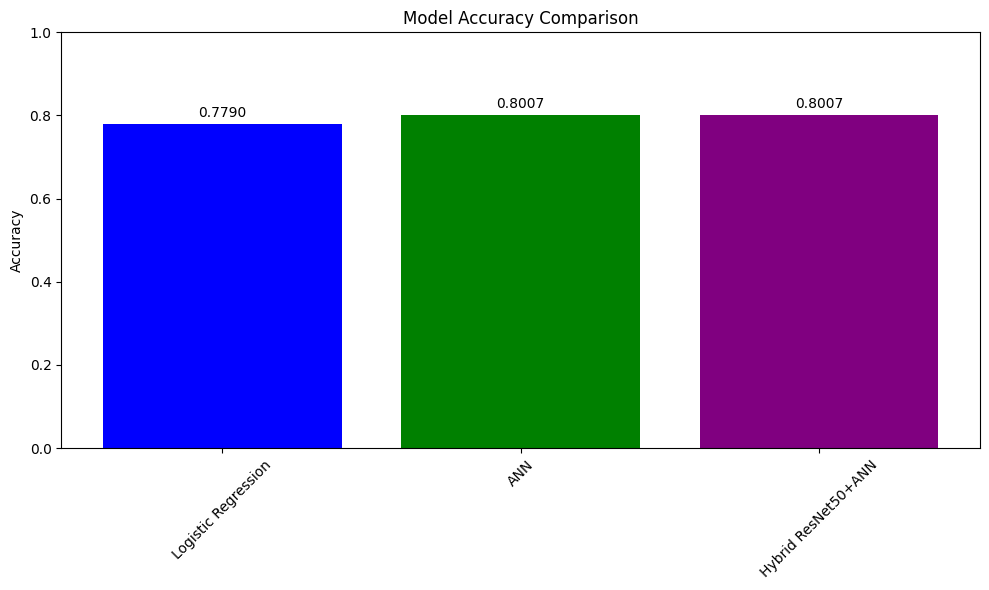


Hybrid Model Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        23
         bcc       0.00      0.00      0.00        26
         bkl       0.00      0.00      0.00        66
          df       0.00      0.00      0.00         6
         mel       0.00      0.00      0.00        34
          nv       0.80      1.00      0.89       663
        vasc       0.00      0.00      0.00        10

    accuracy                           0.80       828
   macro avg       0.11      0.14      0.13       828
weighted avg       0.64      0.80      0.71       828



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


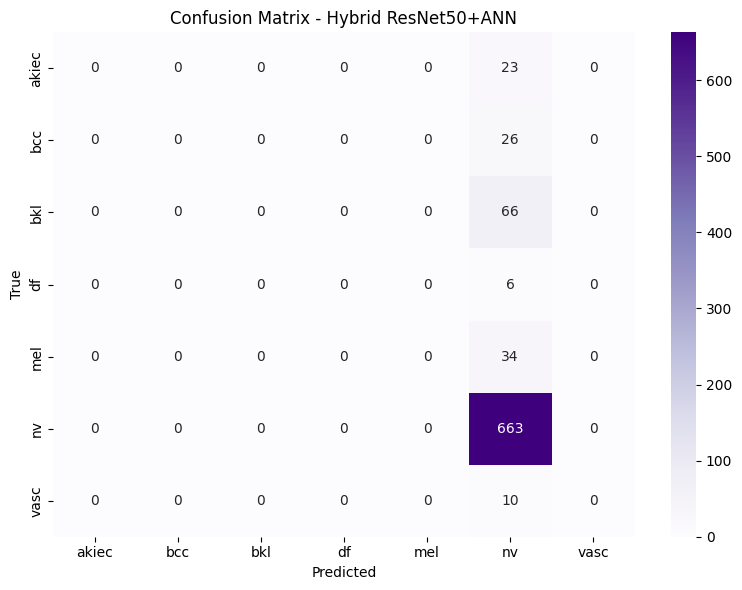

In [ ]:
# model setup
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False  # freeze backbone for faster training

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)       # just one dense layer
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train frozen base for a quick run
model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=2,            # fewer epochs for speed
    batch_size=8,
    verbose=1
)

# fine-tuning
for layer in base_model.layers[-20:]:  # unfreeze last 20 layers only
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=1,            # one quick fine-tune pass
    batch_size=8,
    verbose=1
)

# Evaluation
loss, acc = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Simplified Hybrid Accuracy: {acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)

# bar chart comparison (only if all accuracies available)
models = ['Logistic Regression', 'ANN', 'Hybrid ResNet50+ANN']
accuracies = [logreg_accuracy, ann_accuracy, acc]  # make sure all vars exist

plt.figure(figsize=(10, 6))
plt.bar(range(len(models)), accuracies, color=['blue', 'green', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.xticks(range(len(models)), models, rotation=45)
plt.tight_layout()
plt.show()

# classification report
print("\nHybrid Model Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=class_names))

# confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Hybrid ResNet50+ANN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()